In [171]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fastai.vision.all import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [179]:
path = untar_data(URLs.IMAGENETTE_160)

In [180]:
def get_transforms(use_augmentation=False):
    if use_augmentation:
        return transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
        ])

def create_dataloader(use_augmentation=False):
    transform = get_transforms(use_augmentation)
    train_dataset = ImageFolder(root=path/'train', transform=transform)
    val_dataset = ImageFolder(root=path/'val', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return train_loader, val_loader

In [199]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_acc = 0.0 

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images, labels
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        val_loss_epoch = val_loss / val_total
        val_acc_epoch = val_corrects / val_total
        
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)

        scheduler.step()

        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        print(f'Validation Loss: {val_loss_epoch:.4f}, Validation Accuracy: {val_acc_epoch:.4f}')
        print()

    return train_losses, val_losses, train_accs, val_accs, all_labels, all_preds

In [200]:
def plot_curves(train_losses, val_losses, train_accs, val_accs, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot|
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b', label='Training accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [201]:
def initialize_model(num_classes = 10, freeze = False, use_pretrained=True):
    if use_pretrained == True:
        model = models.resnet18(weights="IMAGENET1K_V1")
    else:
        model = models.resnet18()

    if freeze == True:
        for name, param in model.named_parameters():
            if "bn" not in name:
                param.requires_grad = False
    else:
        for name, param in model.named_parameters():
            param.requires_grad = False
                
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [202]:
from torch.optim import lr_scheduler

num_classes = 10
num_epochs = 10

model = initialize_model(freeze = False, use_pretrained=True)
train_loader, val_loader = create_dataloader(use_augmentation=True)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

# FREEZED BN

In [203]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model, train_loader, val_loader, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs)

Epoch 1/10
----------
Training Loss: 0.5829, Training Accuracy: 0.8447
Validation Loss: 0.2663, Validation Accuracy: 0.9213

Epoch 2/10
----------
Training Loss: 0.2787, Training Accuracy: 0.9147
Validation Loss: 0.2452, Validation Accuracy: 0.9213

Epoch 3/10
----------
Training Loss: 0.2469, Training Accuracy: 0.9258
Validation Loss: 0.2189, Validation Accuracy: 0.9276

Epoch 4/10
----------
Training Loss: 0.2293, Training Accuracy: 0.9288
Validation Loss: 0.2151, Validation Accuracy: 0.9297

Epoch 5/10
----------
Training Loss: 0.2075, Training Accuracy: 0.9324
Validation Loss: 0.2040, Validation Accuracy: 0.9317

Epoch 6/10
----------
Training Loss: 0.2014, Training Accuracy: 0.9357
Validation Loss: 0.1977, Validation Accuracy: 0.9338

Epoch 7/10
----------
Training Loss: 0.1950, Training Accuracy: 0.9389
Validation Loss: 0.2023, Validation Accuracy: 0.9373

Epoch 8/10
----------
Training Loss: 0.2065, Training Accuracy: 0.9353
Validation Loss: 0.2062, Validation Accuracy: 0.9279



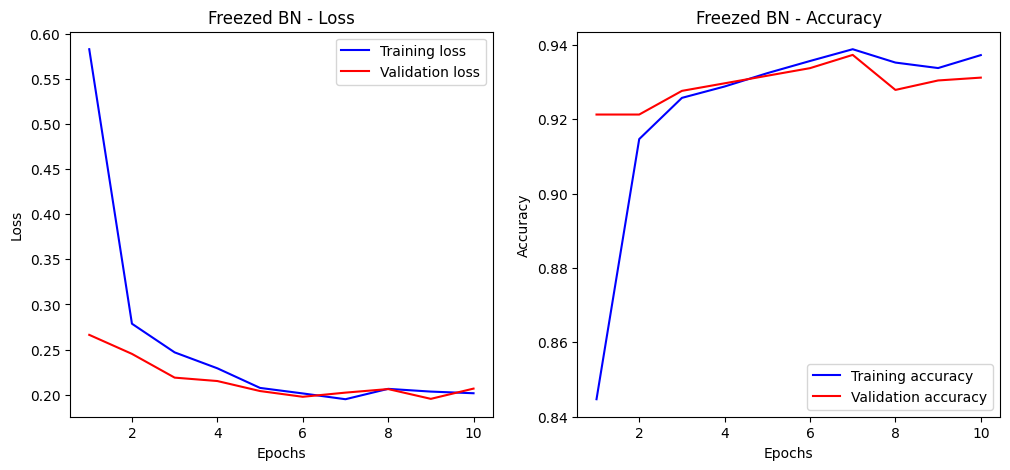

In [204]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'Freezed BN')

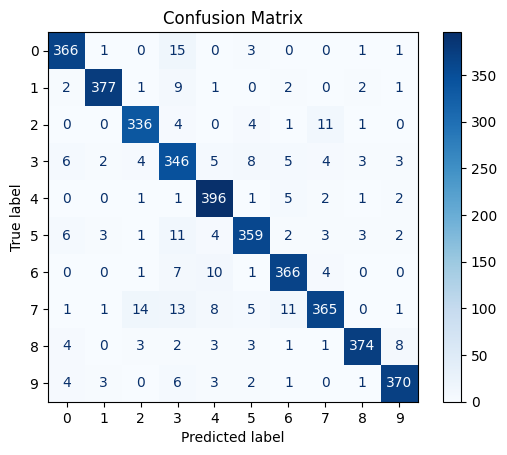

In [205]:
plot_confusion_matrix(all_labels, all_preds, num_classes)

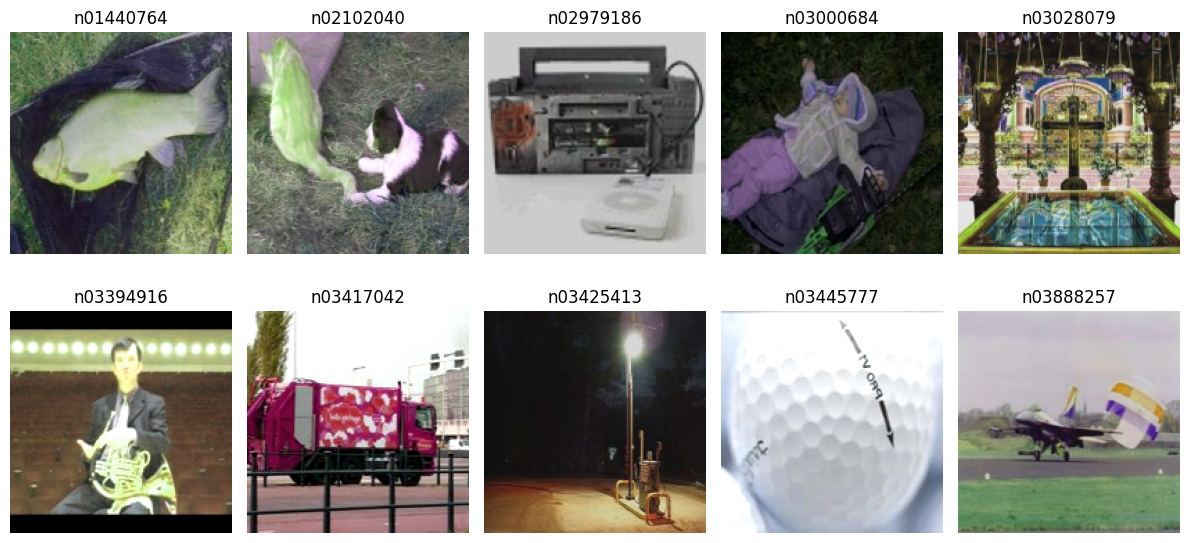

In [210]:
class_names = ImageFolder(root=path/'train').classes

images_per_class = {class_name: None for class_name in class_names}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label.item()]
        if images_per_class[class_name] is None:
            images_per_class[class_name] = img
    if all(images_per_class[class_name] is not None for class_name in class_names):
        break

plt.figure(figsize=(12, 6))
for i, (class_name, img_tensor) in enumerate(images_per_class.items()):
    plt.subplot(2, 5, i + 1)  
    if img_tensor is not None:
        plt.imshow(img_tensor.permute(1, 2, 0))
        plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [211]:
tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute

SyntaxError: invalid syntax (4177027281.py, line 1)

In [212]:
from torch.optim import lr_scheduler

num_classes = 10
num_epochs = 10

model = initialize_model(freeze = True, use_pretrained=True)
train_loader, val_loader = create_dataloader(use_augmentation=True)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [213]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model, train_loader, val_loader, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs)

Epoch 1/10
----------
Training Loss: 0.5709, Training Accuracy: 0.8495
Validation Loss: 0.2754, Validation Accuracy: 0.9185

Epoch 2/10
----------
Training Loss: 0.2855, Training Accuracy: 0.9158
Validation Loss: 0.2469, Validation Accuracy: 0.9208

Epoch 3/10
----------
Training Loss: 0.2537, Training Accuracy: 0.9207
Validation Loss: 0.2111, Validation Accuracy: 0.9315

Epoch 4/10
----------
Training Loss: 0.2347, Training Accuracy: 0.9246
Validation Loss: 0.2421, Validation Accuracy: 0.9205

Epoch 5/10
----------
Training Loss: 0.2159, Training Accuracy: 0.9303
Validation Loss: 0.2035, Validation Accuracy: 0.9310

Epoch 6/10
----------
Training Loss: 0.2100, Training Accuracy: 0.9329
Validation Loss: 0.1991, Validation Accuracy: 0.9358

Epoch 7/10
----------
Training Loss: 0.2052, Training Accuracy: 0.9347
Validation Loss: 0.1926, Validation Accuracy: 0.9338

Epoch 8/10
----------
Training Loss: 0.2025, Training Accuracy: 0.9333
Validation Loss: 0.2038, Validation Accuracy: 0.9294



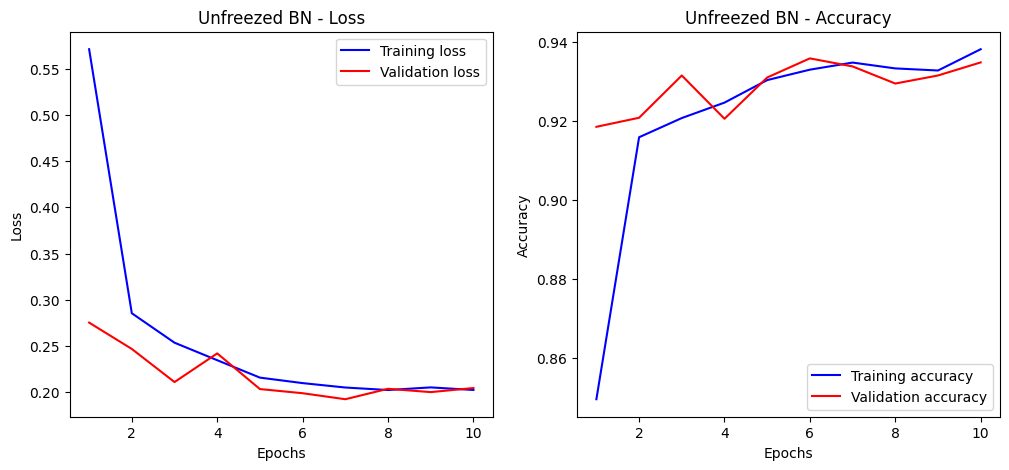

In [216]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'Unfreezed BN')

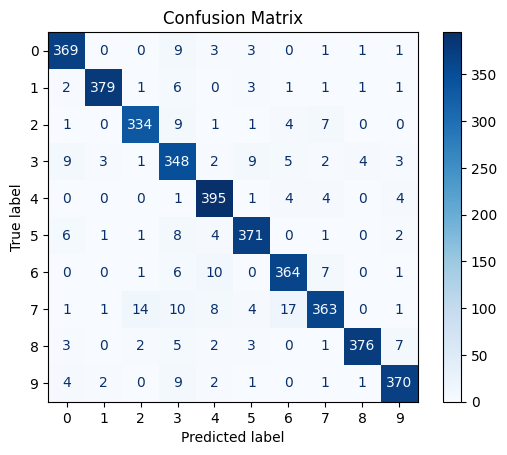

In [215]:
plot_confusion_matrix(all_labels, all_preds, num_classes)